In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/thanos')
from keras.layers import Input, Dense, LSTM, RepeatVector
from keras.models import Model
from keras import callbacks
import datetime

In [20]:
sample_data = pd.read_csv('sample_simulated_transaction_history.csv')

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [23]:
sample_data.shape

(939512, 11)

In [24]:
sample_data.date = pd.to_datetime(sample_data.date)

In [25]:
def name_trunc(x):
    x = "_".join(x.split("_", 2)[:2])
    return x

In [26]:
sample_data.id = sample_data.id.map(lambda x:name_trunc(x))

In [27]:
df = []
depts = []
for i in sample_data.dept.unique():
    df.append(sample_data[(sample_data.dept == i)].reset_index(drop = True)[['id','date', 'purchaseamount']])
    depts.append(i)

In [28]:
sample_data.isnull().values.any()

False

In [29]:
def obtain_encoding(dataframe, depts, sample_data, pre_end_date, pre_start_date, pre_eval, EPOCHS, BATCH_SIZE, DIM):
    complete_data = pd.DataFrame({'date':pd.date_range(sample_data.date.min(), sample_data.date.max())})
    complete_data.set_index('date', inplace = True)
    for i in df[0].id.unique():
        specific_donor = df[0][(df[0].id == i)].reset_index(drop = True).groupby(['date']).max().drop(labels = ['id'], axis = 1).reindex(pd.date_range(sample_data.date.min(), sample_data.date.max()), fill_value = 0)
        complete_data[i] = pd.DataFrame({i:specific_donor.purchaseamount})

    xtrain = complete_data[pre_start_date:pre_end_date]
    ytrain = complete_data[pre_end_date:pre_eval]
    
    x_train = xtrain.T.values
    y_train = ytrain.T.values
    
    xtrain1 = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    ytrain1 = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
    
    encoding_dim = DIM

    inputs = Input(shape=(xtrain1.shape[1], 1))
    encoded = LSTM(encoding_dim)(inputs)

    decoded = RepeatVector(ytrain1.shape[1])(encoded)
    decoded = LSTM(1, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    sequence_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

    history = sequence_autoencoder.fit(xtrain1, ytrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                   callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')])

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.savefig('performance-%s.png' % depts)
    
    encoded_mat = encoder.predict(xtrain1)
    new_df = pd.DataFrame(encoded_mat)
    new_df[new_df<0] = 0
    new_df.insert(loc=0, column='id', value=complete_data.columns.values)

    return new_df

Epoch 1/1000
2617/2617 [==============================] - 9s 3ms/step - loss: 448.0746 - acc: 0.9956
Epoch 2/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 447.6692 - acc: 0.9946
Epoch 3/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.3377 - acc: 0.1130
Epoch 4/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.1627 - acc: 0.0356
Epoch 5/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.0012 - acc: 0.0326
Epoch 6/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.9189 - acc: 0.0323
Epoch 7/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.8610 - acc: 0.0322
Epoch 8/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.8196 - acc: 0.0321
Epoch 9/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.7750 - acc: 0.0394
Epoch 10/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.7094 - a

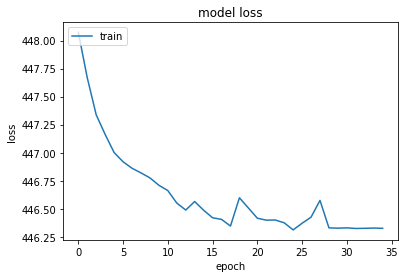

Epoch 1/1000
2617/2617 [==============================] - 9s 3ms/step - loss: 447.5840 - acc: 0.9913
Epoch 2/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.0477 - acc: 0.9824
Epoch 3/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 446.9090 - acc: 0.0837
Epoch 4/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.8108 - acc: 0.0321
Epoch 5/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.7357 - acc: 0.0321
Epoch 6/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.6800 - acc: 0.0444
Epoch 7/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 446.6479 - acc: 0.0334
Epoch 8/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.5945 - acc: 0.0399
Epoch 9/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5119 - acc: 0.1440
Epoch 10/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5432 - a

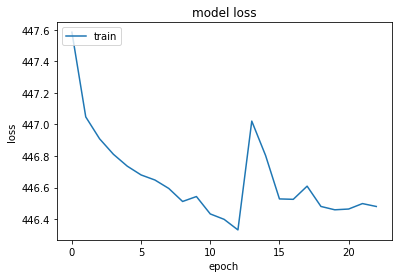

Epoch 1/1000
2617/2617 [==============================] - 9s 4ms/step - loss: 448.3665 - acc: 0.9956
Epoch 2/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.8810 - acc: 0.9956
Epoch 3/1000
2617/2617 [==============================] - 10s 4ms/step - loss: 447.4900 - acc: 0.4260
Epoch 4/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.2879 - acc: 0.0342
Epoch 5/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.1761 - acc: 0.0282
Epoch 6/1000
2617/2617 [==============================] - 9s 4ms/step - loss: 447.0984 - acc: 0.0328
Epoch 7/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.0270 - acc: 0.0357
Epoch 8/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.0305 - acc: 0.1365
Epoch 9/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.0251 - acc: 0.0126
Epoch 10/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.9253 - 

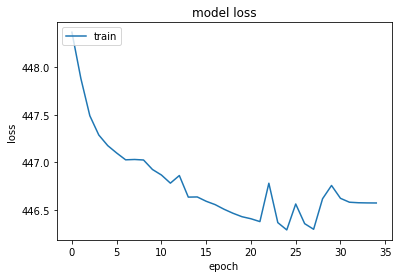

Epoch 1/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 447.9158 - acc: 0.9956
Epoch 2/1000
2617/2617 [==============================] - 7s 2ms/step - loss: 447.5171 - acc: 0.9933
Epoch 3/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.1399 - acc: 0.0917
Epoch 4/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.9490 - acc: 0.0327
Epoch 5/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.8110 - acc: 0.0323
Epoch 6/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.7279 - acc: 0.0322
Epoch 7/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.6772 - acc: 0.0323
Epoch 8/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.6058 - acc: 0.0322
Epoch 9/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.5524 - acc: 0.0321
Epoch 10/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.5145 - a

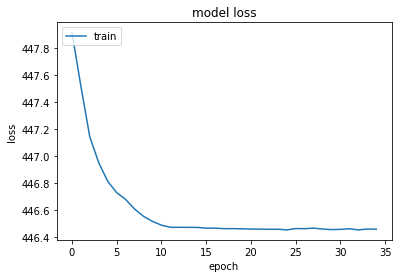

Epoch 1/1000
2617/2617 [==============================] - 9s 3ms/step - loss: 447.1773 - acc: 0.9926
Epoch 2/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.7541 - acc: 0.6608
Epoch 3/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.5552 - acc: 0.0719
Epoch 4/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5274 - acc: 0.0641
Epoch 5/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5039 - acc: 0.0641
Epoch 6/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.4867 - acc: 0.0479
Epoch 7/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5012 - acc: 0.0324
Epoch 8/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.4914 - acc: 0.0367
Epoch 9/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.4723 - acc: 0.0349
Epoch 10/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.4640 - a

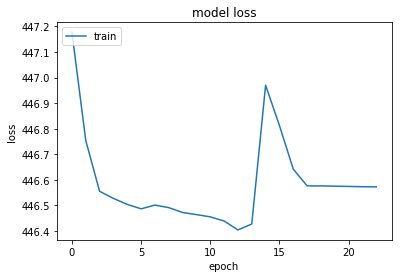

Epoch 1/1000
2617/2617 [==============================] - 8s 3ms/step - loss: 448.0105 - acc: 0.9956
Epoch 2/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.5079 - acc: 0.9956
Epoch 3/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 447.1513 - acc: 0.2894
Epoch 4/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.9757 - acc: 0.0326
Epoch 5/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.8654 - acc: 0.0323
Epoch 6/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.7564 - acc: 0.0321
Epoch 7/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.6582 - acc: 0.0321
Epoch 8/1000
2617/2617 [==============================] - 6s 2ms/step - loss: 446.5762 - acc: 0.0321
Epoch 9/1000
2617/2617 [==============================] - 7s 3ms/step - loss: 446.5303 - acc: 0.0321
Epoch 10/1000
2617/2617 [==============================] - 10s 4ms/step - loss: 446.5047 - 

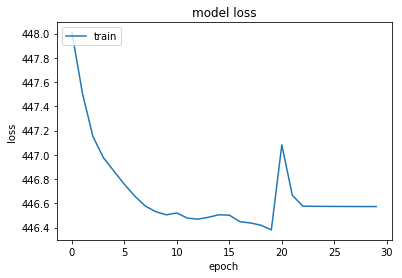

In [30]:
encod = []
pre_start_date = '2015-01-01'
pre_end_date = '2016-01-01'
pre_eval = '2016-01-31'
for i in range(len(df)):
    encod.append(obtain_encoding(df[i], depts[i], sample_data, pre_end_date, pre_start_date, pre_eval, EPOCHS=1000, BATCH_SIZE=500, DIM=50))
    encod[-1].to_csv('encoding_of_%s_customers.csv' %depts[i])